# Using BERT for tweets classification

This notebook uses BERT for kaggle competition ["Real or Not? NLP with Disaster Tweets"](https://www.kaggle.com/c/nlp-getting-started/overview/description). Specifically, it fine-tunes BERT to predict whether given tweet describes a real disaster that has actually occurred or it's just a metaphorical description. The task is analogous to binary sentiment classification, where, say, "positive" sentiment corresponds to "disaster" (1) while "negative" corresponds to "non-disaster" (0).

It is a brief overview of BERT fine-tuning capabilities and its ability to adjust to new tasks/datasets while preserving near state-of-the-art performance.

General code structure was mostly taken from [this brilliant post](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) (and modified/improved for specific task purposes). IMO the author's way to format and feed the data into BERT by organizing it into a dictionary is the cleanest one out there.

# BERT basics

BERT (Bidirectional Encoder Representations from Transformers) was presented in late 2018 by Jacob Devlin, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova of Google AI. As the authors [claim](https://arxiv.org/abs/1810.04805), regular Transformer models like GPT incorporate unidirectional sentence analysis, implementing attention mechanism from left to right, thus limiting the opportunities of context understanding. BERT alleviates this constraint by using a "masked language model" during training (basically masking a few words from a sentence and making model guess them) and with that manages to enable pre-trained deep bidirectional representations. This is also different from models like ELMo which used LSTMs of different directions and then simply concatenated hidden states in the end which made impossible simultaneous, integral capturing of the sentence semantic structure.

In terms of architecture, BERT represents the encoder part of GPT, only a bidirectional one.

![](https://cdn-images-1.medium.com/max/800/0*m_kXt3uqZH9e7H4w.png)

First, input sequence is fed into the model where it's being tokenized and transformed into WordPiece embeddings representation. Note that each separate sentence starts with `[CLS]` token and ends with `[SEP]`. We have two more embedding layers, "sentence embeddings", and "positional embeddings". The former helps BERT to distinguish between sentences, the latter is responsible for representing words positions within the sentence. Remember that with dismissing traditional RNNs we lost the ability to track the sequential nature of the sentence, so these embedding layers are here to compensate for that. Final token representation is a sum of 3 embeddings. This is followed by regular self-attention/normalize layers, as in original Transformers, described in iconic ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) paper. We will see whole BERT architecture printed out later in this notebook.

# Imports

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from collections import defaultdict
from textwrap import wrap

!pip install transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Reading&Processing data

I've tried out a lot of various ways to preprocess tweets including manual cleaning, removing stopwords, lemmatizing, spell corrections, slang replacement, using libraries like texthero, spellchecker, tweet-preprocessor, contractions, etc., and also merging text column with keyword and/or location. Ironically, the best performance was achieved when using BERT on raw text, with even hyperlinks left untouched. The only thing changed is target relabeling in the train set (special thanks to [this kaggle notebook](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)). Note that the test set also contains duplicates that might be labeled differently (since labeling was done manually by humans), which of course influences the score.

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Relabeling targets

In [ ]:
train_df['target_relabeled'] = train_df['target'].copy()

train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0


New dataframes for simplicity

In [ ]:
train_cleaned = pd.DataFrame({'text': train_df.text,
                         'label': train_df.target_relabeled})
test_cleaned = pd.DataFrame({'text': test_df.text})

In [ ]:
pd.set_option('display.max_colwidth', -1)
print(train_cleaned.head(40))

                                                                                                                                            text  \
0   Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                          
1   Forest fire near La Ronge Sask. Canada                                                                                                         
2   All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected          
3   13,000 people receive #wildfires evacuation orders in California                                                                               
4   Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school                                                        
5   #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfir

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


Here BERT was used as a part of `transformers` class of huggingface library, available for PyTorch. We're using `uncased` version, so tokenizing would be applied to lowercased text. I've seen some tutorials which used `cased` version for sentiment classification and got better accuracy (makes sence for "COOL" sounds more emotionally expressive than "cool") but for this task `uncased` seemes to work better.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, 
                                          do_lower_case=True)

# Text preprocessing for BERT

In order to feed the text to BERT, we need to properly format it first. This procedure involves padding (truncating) sentences to a certain length, adding special symbols at the beginning and at the end of each sentence (`[CLS]` and `[SEP]`), and deriving an attention mask that simply allows BERT to distinguish between actual sentence tokens and zero padding (it contains `1`s for real tokens and `0`s for padded part). Instead of doing it all manually, we can make use of `encode_plus` method.

But first, we should come up with padding length. Max/default BERT value is `512`, but it's computationally demanding, so people usually go with the length of the longest sentence in the dataset. Despite in our case, the longest tokenized tweet was 84 tokens long, choosing the length of `128` showed better performance (although worse than 256, 512, etc.).

Max length:  84
                                        


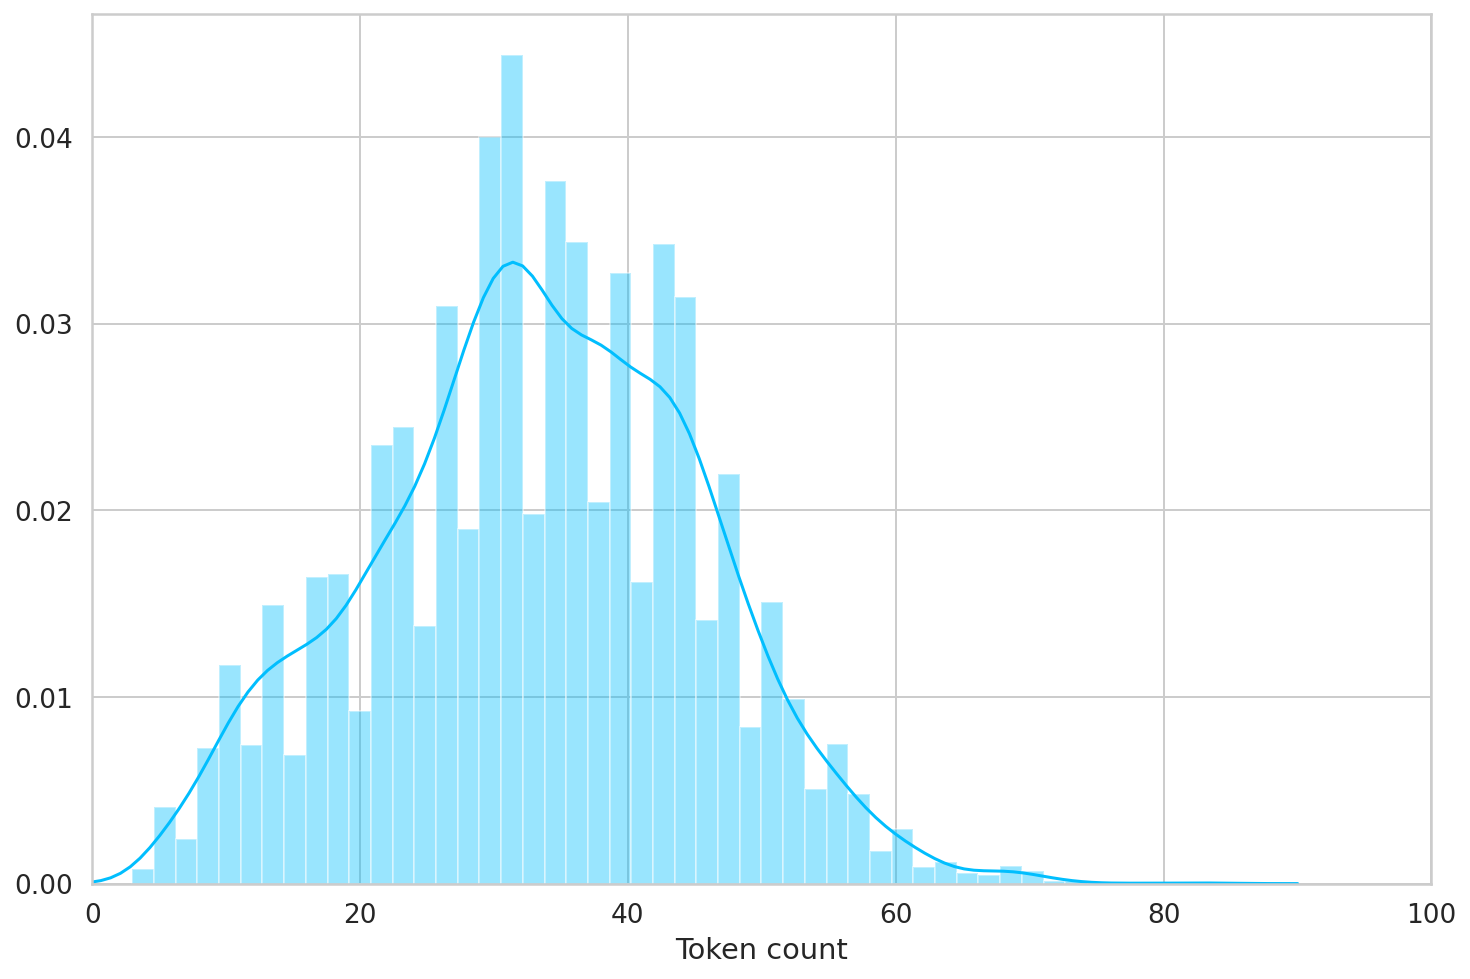

In [ ]:
token_lens = []

for tweet in list(train_cleaned.text)+list(test_cleaned.text):
  tokens = tokenizer.encode(tweet, truncation=True, max_length=512)
  token_lens.append(len(tokens))

print('Max length: ', max(token_lens))
print(' '*40)

sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 128

Here we're creating a class that takes all the hyperparameters and utilizes `encode_plus` tokenizer method to return a dictionary containing tweet text, tokenized tweet, attention mask and tweet label.

In [ ]:
class TweetDataset(Dataset):

  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True, # add [CLS] and [SEP]
      max_length=self.max_len, # 128
      truncation=True, # to avoid warnings
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

Train-valid-test split of the training set (0.8, 0.1, 0.1).

In [ ]:
df_train, df_test = train_test_split(train_cleaned, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((6090, 2), (761, 2), (762, 2))

Helper function to create PyTorch data loader.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TweetDataset(
    tweets=df.text.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Here you can see an original tweet, its tokenized representation, attention mask, and label. Note that BERT doesn't tokenize words by simply turning them into numbers sequentially, but uses separate parts of words instead (with total vocab size of 30000), that's why by looking at the original sentence you'll never know its length after tokenizing.

As you can see, `[CLS]` token has index 101, `[SEP]` is 102.

In [ ]:
print([i for i in train_data_loader][0]['tweet_text'][0])
print([i for i in train_data_loader][0]['input_ids'][0])
print([i for i in train_data_loader][0]['attention_mask'][0])
print([i for i in train_data_loader][0]['labels'][0])

Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR
tensor([  101, 26103,  1998,  7481,  4106,  1997,  2342,  2000,  2224,  9593,
         5968,  1999,  3386,  1012,  1001, 20168, 19841,  2887,  2510,  4188,
         7806,  1012, 16770,  1024,  1013,  1013,  1056,  1012,  2522,  1013,
         1058, 14227,  3723, 25856,  2102, 16523,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
 

In [ ]:
data = next(iter(train_data_loader))

print(data['input_ids'].shape) # batch_size * tweet length
print(data['attention_mask'].shape)  # batch_size * tweet length
print(data['labels'].shape) # batch_size

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


We use a pre-trained base version of BERT model (110M parameters, 12-headed attention, 12 Transformer layers, hidden states of size 768). huggingface provides `BertForSequenceClassification` class with additional linear layer specifically for classification tasks (remember that BERT could be used for variety of NLP (NLU) tasks, such as question answering, named entity recognition, classification), but raw BERT allows for more flexibility when adding head layers on top (it outputs only hidden states).

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# The Model

Defining the model architecture. Here we're using pooled_output which is just the hidden state of the `[CLS]` token from the last layer put through a linear layer with `tanh` activation without changes in dimensionality. 

![](https://miro.medium.com/max/500/1*9KZDq9Zu2kxdZxS5Ip5JRg.png
)

This is a common way to extract data from BERT for classification (reminds of a regular LSTM classification), and it's equivalent to `BertForSequenceClassification` except for dropout tuning. We could've also extracted hidden states for all tokens, and then concatenate or average them. I've tried out various architectures, including adding more linear layers on top, adding sigmoid activation, tweaking the number of nodes, dropout probability, etc., but the one below resulted in the best performance.

In [ ]:
class DisasterClassifier(nn.Module):

  def __init__(self, n_classes):
    super(DisasterClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(.4)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Specifying the number of classes and printing out whole BERT architecture, including the pooler layer that we use as output and our custom linear layer with `2` neurons as final output.

In [ ]:
model = DisasterClassifier(2)
model = model.to(device)

print(model)

DisasterClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 128])
torch.Size([32, 128])


# Training

We're conducting fine-tuning for `4` epochs here (only 3 of which are usually helpful), using `AdamW` optimizer (proposed by huggingface, to be fair, regular Adam showed almost identical results for this task), learning rate of `0.00001`, and a default scheduler. Since we have 2 logits output we use cross-entropy as our loss function, which will apply softmax internally.

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Two helper functions for training and validation are used. Each returns accuracy, loss, and f1-score of the epoch. The validation function also returns a full classification report for later evaluation of test results. Note that we're clipping gradients to the value of `1` to prevent exploding gradients.

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  y_pred_tr = []
  y_true_tr = []

  losses = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1) # choose index with max value
    
    loss = loss_fn(outputs, labels)
    
    for i in preds.cpu().numpy():
        y_pred_tr.append(i)
    for i in labels.cpu().numpy():
        y_true_tr.append(i)
    
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return accuracy_score(y_true_tr, y_pred_tr), np.mean(losses), \
         f1_score(y_true_tr, y_pred_tr)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []

  y_pred_val = []
  y_true_val = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      for i in preds.cpu().numpy():
        y_pred_val.append(i)
      for i in labels.cpu().numpy():
        y_true_val.append(i)

      losses.append(loss.item())

  return accuracy_score(y_true_val, y_pred_val), np.mean(losses), \
         f1_score(y_true_val, y_pred_val), \
         classification_report(y_true_val, y_pred_val)

Since the goal of this kaggle competition is to achieve maximum [f1-score](https://en.wikipedia.org/wiki/F1_score) (harmonic mean of the precision and recall), we'll be saving the model after each increase in validation f1.

In [ ]:
%%time

history = defaultdict(list)
best_f1 = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, train_f1 = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss: {train_loss}, Accuracy: {train_acc}, f1: {train_f1}')

  val_acc, val_loss, val_f1, _ = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss: {val_loss}, Accuracy: {val_acc}, f1: {val_f1}')
  
  # saving to history
  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss.item())
  history['train_f1'].append(train_f1.item())
  history['val_f1'].append(val_f1.item())

  # if current f1 is larger than the previous one, save the model
  if val_f1 > best_f1:
    torch.save(model.state_dict(), 'best_model_state.pt')
    best_f1 = val_f1

Epoch 1/4
----------
Train loss: 0.4453192315020486, Accuracy: 0.8055829228243021, f1: 0.7605177993527508
Val loss: 0.39713778843482334, Accuracy: 0.8331143232588699, f1: 0.7900826446280991
Epoch 2/4
----------
Train loss: 0.3014472157777292, Accuracy: 0.8845648604269294, f1: 0.8597086409898222
Val loss: 0.4201988863448302, Accuracy: 0.8318002628120894, f1: 0.7928802588996764
Epoch 3/4
----------
Train loss: 0.2162010245298216, Accuracy: 0.9226600985221675, f1: 0.9068985965605849
Val loss: 0.5439890411992868, Accuracy: 0.812089356110381, f1: 0.7843137254901962
Epoch 4/4
----------
Train loss: 0.17843186635894612, Accuracy: 0.9384236453201971, f1: 0.926166568222091
Val loss: 0.5631393417716026, Accuracy: 0.8186596583442839, f1: 0.7863777089783281
CPU times: user 3min 22s, sys: 1min 37s, total: 5min
Wall time: 5min 8s


Thanks to the initial BERT parameters' ability to generalize, fine-tuning didn't take much time.

Plot training history of f1-score, accuracy, and losses.

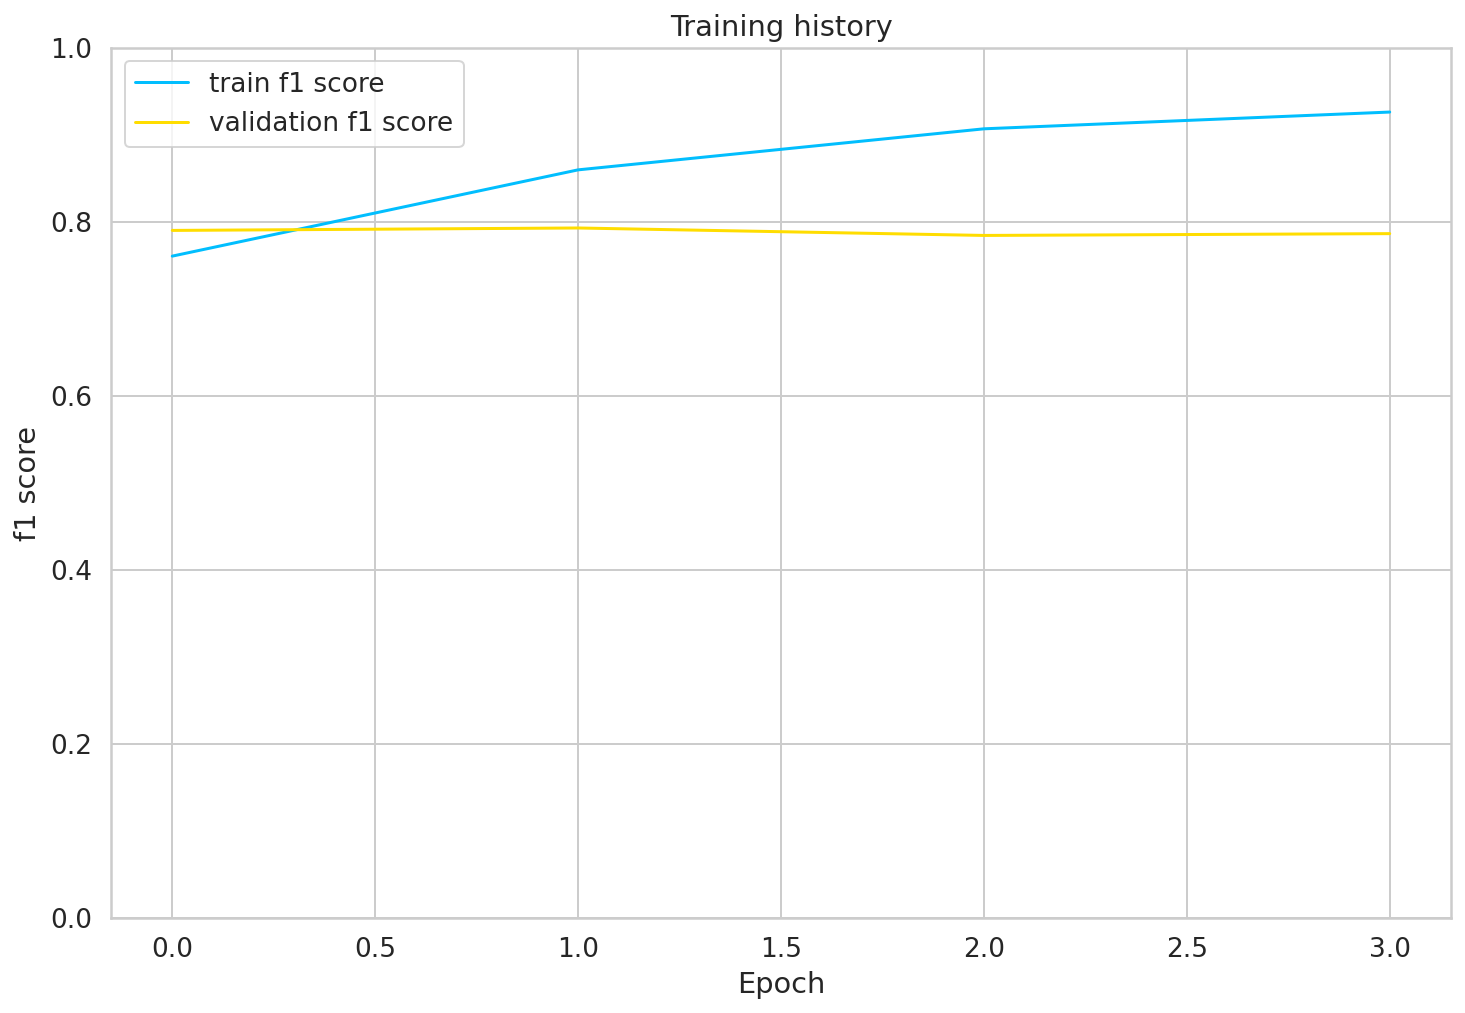

In [ ]:
plt.plot(history['train_f1'], label='train f1 score')
plt.plot(history['val_f1'], label='validation f1 score')

plt.title('Training history')
plt.ylabel('f1 score')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

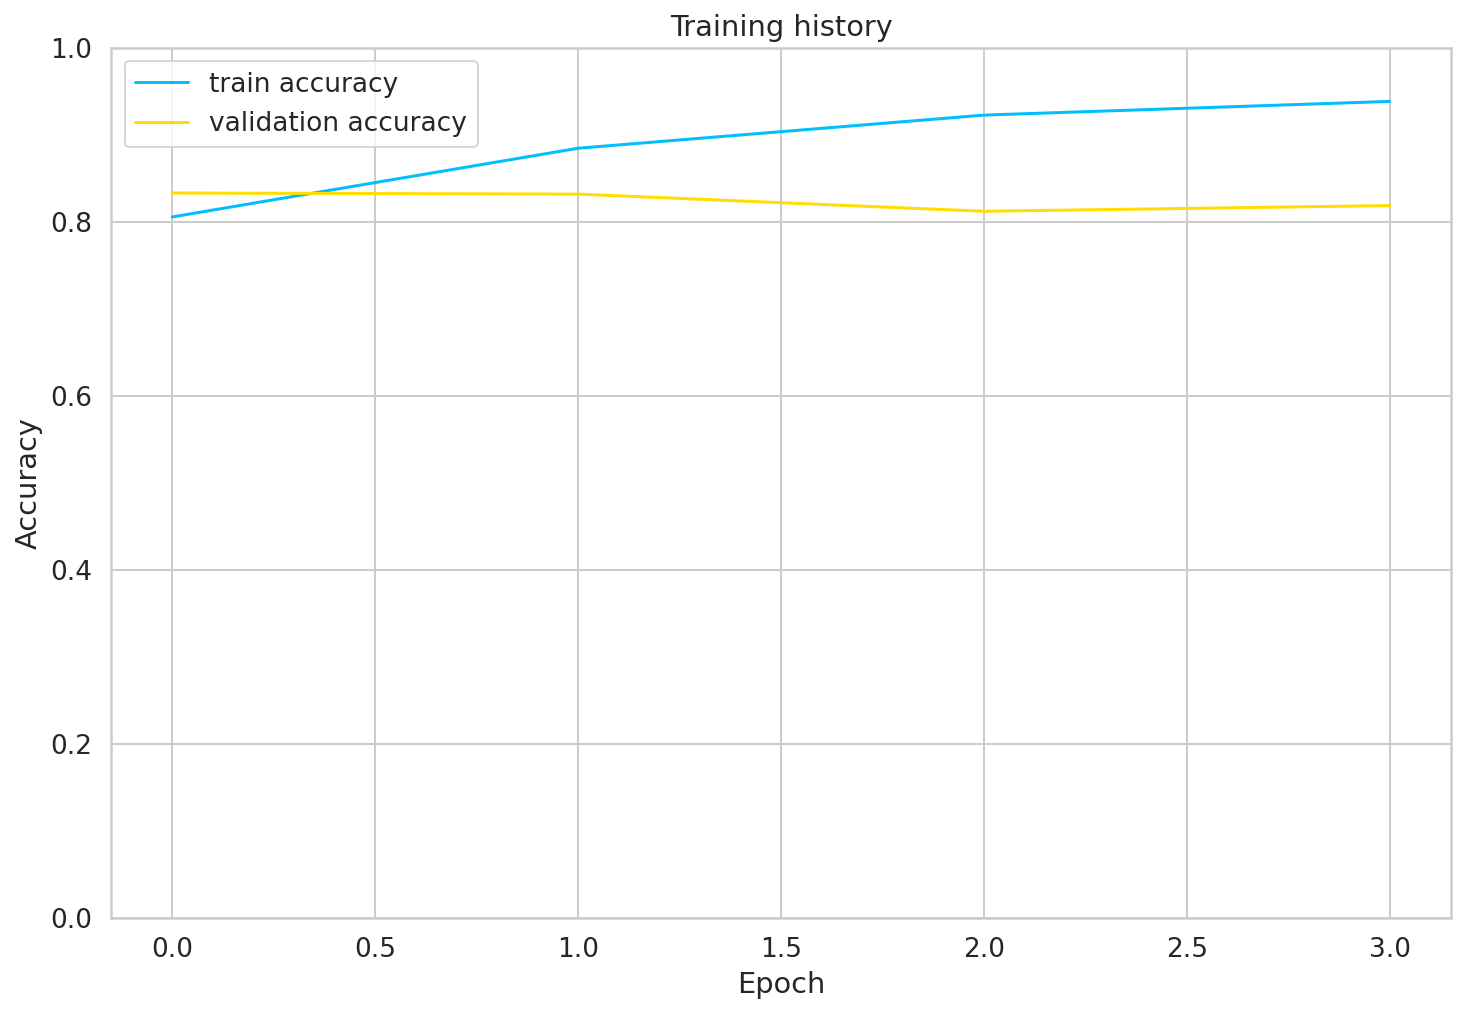

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

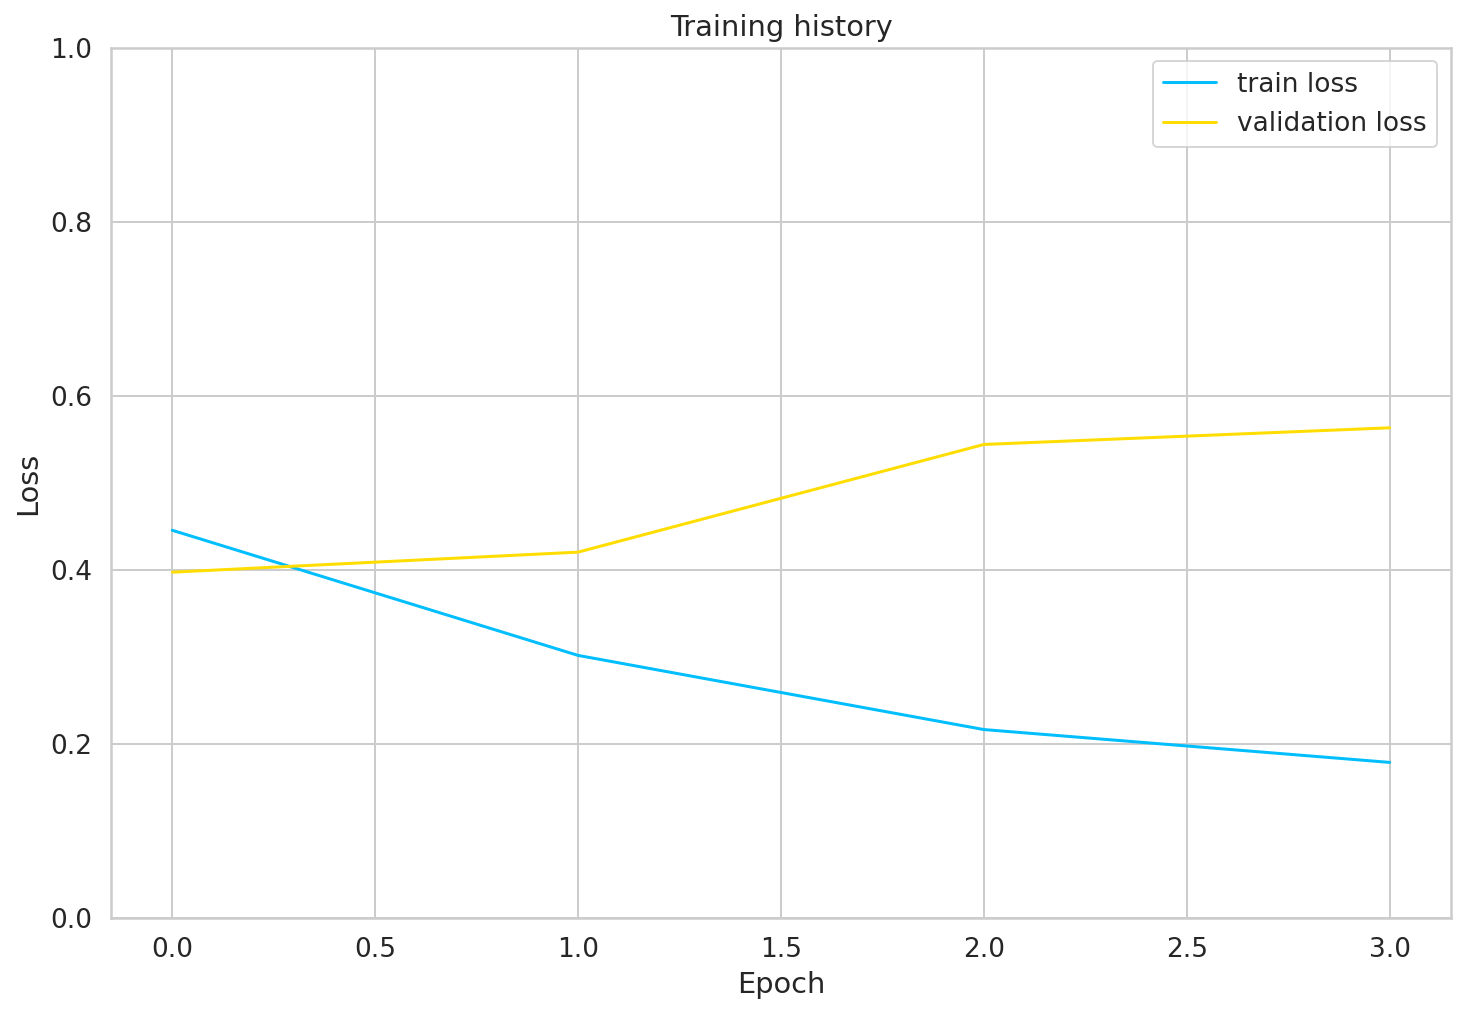

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

No observable progress in validation metrics throughout 4 epochs. However, validation f1-score is slightly higher during 2nd epoch, so we save the model at that point.

Reloading the model

In [ ]:
model = DisasterClassifier(2)
model = model.to(device)
model.load_state_dict(torch.load('best_model_state.pt'))

<All keys matched successfully>

# Evaluation

Classification report on the test set. We're seeing that the model has a little more trouble detecting real disaster tweets, with disaster recall being `0.82` against `0.91` for fake disaster (it mistakes real ones for fake ones).

Overall test f1-score on 762 tweets is about `84.3%` and test accuracy is ~`87%`, which is almost 10% improvement comparing to the regular LSTM model I have been using for this competition earlier.

In [ ]:
test_acc, _, f1, report = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
print(f'Test f1 score: {round(f1*100, 3)}%')
print(f'Test accuracy: {round(test_acc.item()*100, 3)}%')
print('Report:')
print(report)

Test f1 score: 84.295%
Test accuracy: 87.139%
Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       440
           1       0.87      0.82      0.84       322

    accuracy                           0.87       762
   macro avg       0.87      0.86      0.87       762
weighted avg       0.87      0.87      0.87       762



Let's have a quick look at how our model behaves on custom pseudo tweets. The first one is supposed to be about a real disaster, while the second one is a kind of imitation.

In [ ]:
test_tweet_1 = '15,000 people have died because of the earthquakes last year'
test_tweet_2 = 'OMG have you seen those spindrift clouds? They are monstrous!'

In [ ]:
tknzd = [tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    ) for tweet in [test_tweet_1, test_tweet_2]]

As we can see, the model correctly identifies both tweets, however, it has somewhat lower confidence when predicting a label for non-disaster tweets.

In [ ]:
model.eval()

for i in tknzd:
    out = model(i["input_ids"].cuda(), i["attention_mask"].cuda())
    pred = torch.argmax(out)
    # softmax probability for chosen class
    confidence = torch.max(F.softmax(out, dim=1)).detach().cpu().numpy()
    if pred==0:
        res = 'non-disaster'
    else: res = 'disaster'
        
    print(f'Result: {res}, confidence: {round(confidence*100, 2)}%')

Result: disaster, confidence: 99.45%
Result: non-disaster, confidence: 84.29%


Finally, submitting our predictions for the competition.

In [ ]:
test_t_data_loader = DataLoader([tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    ) for tweet in test_cleaned.text.values], batch_size=BATCH_SIZE)

In [ ]:
def get_test_predictions(model, data_loader):
  model = model.eval()

  predictions = []
 
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].squeeze().to(device)
      attention_mask = d["attention_mask"].squeeze().to(device)
      
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      preds = torch.argmax(outputs, dim=1)     
      predictions.extend(preds)

  return torch.stack(predictions).cpu()

In [ ]:
subm = pd.DataFrame({
    'id': test_df.id,
    'target': get_test_predictions(model, test_t_data_loader).numpy()
})

subm.to_csv('submission.csv', index=False)